# DQN

## Setup

### Initialization

In [1]:
from pathlib import Path
import os
import datetime
import logging

import ipdb

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import pandas as pd
import seaborn as sns
from imojify import imojify
from collections import namedtuple, deque

/tmp/ipykernel_446375/3126581302.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from torchinfo import summary

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from utils import Params, random_choice, make_deterministic
from environment_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues
# from environment_lights_tensor import WrappedEnvironment, Actions, CONTEXTS_LABELS
from agent_tensor import EpsilonGreedy
import plotting

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

In [5]:
sns.set_theme(font_scale=1.5)
mpl.rcParams["font.family"] = ["sans-serif"]
mpl.rcParams["font.sans-serif"] = [
    "Fira Sans",
    "Computer Modern Sans Serif",
    "DejaVu Sans",
    "Verdana",
    "Arial",
    "Helvetica",
]
# plt.style.use("ggplot")

In [6]:
now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
now

'2024-02-29_10-40-25'

In [7]:
ROOT_PATH = Path("env").parent
SAVE_PATH = ROOT_PATH / "save"
CURRENT_PATH = SAVE_PATH / now
CURRENT_PATH.mkdir(parents=True, exist_ok=True)  # Create the tree of directories
print(f"Save path: `{CURRENT_PATH.absolute()}`")

Save path: `/oscar/home/apierre3/RL_Olfaction/TriangleTask/save/2024-02-29_10-40-25`


In [8]:
# Configure logging
logfile = CURRENT_PATH / "training.log"
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(logfile)
formatter = logging.Formatter(
    "%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s"
)
handler.setFormatter(formatter)
logger.addHandler(handler)

### Parameters

In [9]:
p = Params(
    # seed=42,
    seed=123,
    n_runs=20,
    total_episodes=500,
    epsilon=0.5,
    alpha=1e-4,
    gamma=0.99,
    # nHiddenUnits=(5 * 5 + 3) * 5,
    nHiddenUnits=128,
    replay_buffer_max_size=10000,
    epsilon_min=0.2,
    epsilon_max=1.0,
    decay_rate=0.005,
    epsilon_warmup=50,
    batch_size=32,
    # target_net_update=200,
    tau=0.005,
)
p

Params(seed=123, n_runs=20, total_episodes=500, epsilon=0.5, epsilon_min=0.2, epsilon_max=1.0, decay_rate=0.005, epsilon_warmup=50, gamma=0.99, alpha=0.0001, nLayers=5, nHiddenUnits=128, n_observations=None, n_actions=None, replay_buffer_max_size=10000, batch_size=32, target_net_update=100, tau=0.005)

In [10]:
if p.batch_size < 2:
    raise ValueError("The batch size needs to be more that one data point")

In [11]:
# Set the seed
GENERATOR = make_deterministic(seed=p.seed)

### Environment definition

In [12]:
# Load the environment
env = WrappedEnvironment(one_hot_state=True, seed=p.seed)

In [13]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 28


### Network definition

In [14]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)

In [15]:
def neural_network():
    # if env.one_hot_state:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=4 * p.n_observations,
    #     ).to(device)
    # else:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=p.nHiddenUnits,
    #     ).to(device)
    # net

    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(device)

    target_net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.nHiddenUnits,
    ).to(device)

    target_net.load_state_dict(net.state_dict())

    return net, target_net

In [16]:
net, target_net = neural_network()
net, target_net

(DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): ReLU()
     (6): Linear(in_features=128, out_features=4, bias=True)
     (7): ReLU()
   )
 ),
 DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): ReLU()
     (6): Linear(in_features=128, out_features=4, bias=True)
     (7): ReLU()
   )
 ))

In [17]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([128, 28]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([4, 128]), torch.Size([4])]


In [18]:
# summary(net, input_size=[state.shape], verbose=0)

### Optimizer

In [19]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

### Explorer

In [20]:
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
    seed=p.seed,
)
episodes = torch.arange(p.total_episodes, device=device)
epsilons = torch.empty_like(episodes, device=device) * torch.nan
for eps_i, epsi in enumerate(epsilons):
    epsilons[eps_i] = explorer.epsilon
    explorer.epsilon = explorer.update_epsilon(episodes[eps_i])

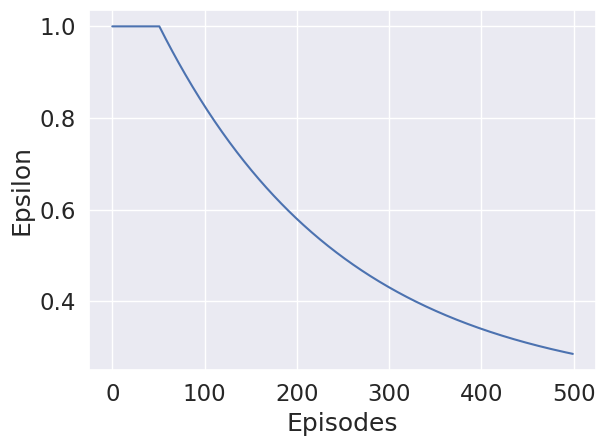

In [21]:
fig, ax = plt.subplots()
sns.lineplot(epsilons.cpu())
ax.set(ylabel="Epsilon")
ax.set(xlabel="Episodes")
fig.tight_layout()
plt.show()

In [22]:
def collect_weights_biases(net):
    biases = {"val": [], "grad": []}
    weights = {"val": [], "grad": []}
    for layer in net.mlp.children():
        layer_params = layer.parameters()
        for idx, subparams in enumerate(layer_params):
            if idx > 2:
                raise ValueError(
                    "There should be max 2 sets of parameters: weights and biases"
                )
            if len(subparams.shape) > 2:
                raise ValueError("The weights have more dimensions than expected")

            if len(subparams.shape) == 1:
                biases["val"].append(subparams)
                biases["grad"].append(subparams.grad)
            elif len(subparams.shape) == 2:
                weights["val"].append(subparams)
                weights["grad"].append(subparams.grad)
    return weights, biases

In [23]:
def params_df_stats(weights, key, current_df=None):
    if not current_df is None:
        last_idx = current_df.index[-1] + 1
        df = current_df
    else:
        last_idx = 0
        df = None

    for idx, val in enumerate(weights[key]):
        tmp_df = pd.DataFrame(
            data={
                "Std": val.detach().cpu().std().item(),
                "Avg": val.detach().cpu().mean().item(),
                "Layer": idx,
                "Index": [last_idx + idx],
            },
            index=[last_idx + idx],
        )

        if df is None:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

## Training

In [24]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

### Main loop

In [25]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=device)
steps = torch.zeros((p.total_episodes, p.n_runs), device=device)
episodes = torch.arange(p.total_episodes, device=device)
# all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]

for run in range(p.n_runs):  # Run several times to account for stochasticity

    # Reset everything
    net, target_net = neural_network()  # eset weights
    optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
    explorer = EpsilonGreedy(
        epsilon=p.epsilon_max,
        epsilon_min=p.epsilon_min,
        epsilon_max=p.epsilon_max,
        decay_rate=p.decay_rate,
        epsilon_warmup=p.epsilon_warmup,
    )
    weights_val_stats = None
    biases_val_stats = None
    weights_grad_stats = None
    biases_grad_stats = None
    replay_buffer = deque([], maxlen=p.replay_buffer_max_size)
    epsilons = []

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(device)
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            state_action_values = net(state).to(device)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            ).item()

            # Record states and actions
            # all_states.append(state)
            # all_actions.append(Actions(action.item()).name)
            all_actions.append(Actions(action).name)

            next_state, reward, done = env.step(action=action, current_state=state)

            # Store transition in replay buffer
            # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1), reward (1x1), done (1x1 bool)]
            done = torch.tensor(done, device=device).unsqueeze(-1)
            replay_buffer.append(
                Transition(
                    state,
                    action,
                    reward,
                    next_state,
                    done,
                )
            )
            if len(replay_buffer) >= p.batch_size:
                transitions = random_choice(
                    replay_buffer,
                    length=len(replay_buffer),
                    num_samples=p.batch_size,
                    generator=GENERATOR,
                )
                batch = Transition(*zip(*transitions, strict=True))
                state_batch = torch.stack(batch.state)
                action_batch = torch.tensor(batch.action, device=device)
                reward_batch = torch.cat(batch.reward)
                next_state_batch = torch.stack(batch.next_state)
                done_batch = torch.cat(batch.done)

                # See DQN paper for equations: https://doi.org/10.1038/nature14236
                state_action_values_sampled = net(state_batch).to(device)  # Q(s_t)
                state_action_values = torch.gather(
                    input=state_action_values_sampled,
                    dim=1,
                    index=action_batch.unsqueeze(-1),
                ).squeeze()  # Q(s_t, a)

                # done_false = torch.argwhere(done_batch == False).squeeze()
                # done_true = torch.argwhere(done_batch == True).squeeze()
                # expected_state_action_values = (
                #     torch.zeros_like(done_batch, device=device)
                # ).float()
                # with torch.no_grad():
                #     if done_true.numel() > 0:
                #         expected_state_action_values[done_true] = reward_batch[
                #             done_true
                #         ]
                #     if done_false.numel() > 0:
                #         next_state_values = (
                #             target_net(next_state_batch[done_false]).to(device).max(1)
                #         )  # Q(s_t+1, a)
                #         expected_state_action_values[done_false] = (
                #             reward_batch[done_false]
                #             + p.gamma * next_state_values.values
                #         )  # y_j (Bellman optimality equation)

                # Compute a mask of non-final states and concatenate the batch elements
                # (a final state would've been the one after which simulation ended)
                non_final_mask = torch.tensor(
                    tuple(map(lambda s: s == False, batch.done)),
                    device=device,
                    dtype=torch.bool,
                )
                non_final_next_states = torch.stack(
                    [s[1] for s in zip(batch.done, batch.next_state) if s[0] == False]
                )

                # Compute V(s_{t+1}) for all next states.
                # Expected values of actions for non_final_next_states are computed based
                # on the "older" target_net; selecting their best reward with max(1).values
                # This is merged based on the mask, such that we'll have either the expected
                # state value or 0 in case the state was final.
                next_state_values = torch.zeros(p.batch_size, device=device)
                if non_final_next_states.numel() > 0 and non_final_mask.numel() > 0:
                    with torch.no_grad():
                        next_state_values[non_final_mask] = (
                            target_net(non_final_next_states).max(1).values
                        )
                # Compute the expected Q values
                expected_state_action_values = reward_batch + (
                    next_state_values * p.gamma
                )

                # Compute loss
                # criterion = nn.MSELoss()
                criterion = nn.SmoothL1Loss()
                loss = criterion(
                    input=state_action_values,  # prediction
                    target=expected_state_action_values,  # target/"truth" value
                )  # TD update

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(
                    net.parameters(), 100
                )  # In-place gradient clipping
                optimizer.step()

                # # Reset the target network
                # if step_count % p.target_net_update == 0:
                #     target_net.load_state_dict(net.state_dict())

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                net_state_dict = net.state_dict()
                for key in net_state_dict:
                    target_net_state_dict[key] = net_state_dict[
                        key
                    ] * p.tau + target_net_state_dict[key] * (1 - p.tau)
                target_net.load_state_dict(target_net_state_dict)

                losses[run].append(loss.item())

                weights, biases = collect_weights_biases(net=net)
                weights_val_stats = params_df_stats(
                    weights, key="val", current_df=weights_grad_stats
                )
                biases_val_stats = params_df_stats(
                    biases, key="val", current_df=biases_val_stats
                )
                biases_grad_stats = params_df_stats(
                    biases, key="grad", current_df=biases_grad_stats
                )
                weights_grad_stats = params_df_stats(
                    weights, key="grad", current_df=weights_val_stats
                )

            total_rewards += reward
            step_count += 1

            # Move to the next state
            state = next_state

            explorer.epsilon = explorer.update_epsilon(episode)
            epsilons.append(explorer.epsilon)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
        logger.info(
            f"Run: {run+1} - Episode: {episode} - Steps: {step_count} - Loss: {loss.item()}"
        )
    weights_val_stats.set_index("Index", inplace=True)
    biases_val_stats.set_index("Index", inplace=True)
    biases_grad_stats.set_index("Index", inplace=True)
    weights_grad_stats.set_index("Index", inplace=True)

Run 7/20 - Episodes:  37%|███▋      | 184/500 [06:26<18:35,  3.53s/it]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Save data to disk

In [30]:
data_path = CURRENT_PATH / "data.npz"
with open(data_path, "wb") as f:
    np.savez(
        f,
        rewards=rewards.cpu(),
        steps=steps.cpu(),
        episodes=episodes.cpu(),
        all_actions=all_actions,
        # losses=losses,
        p=p,
    )

## Visualization

### Load data from disk

In [31]:
# with open(data_path, "rb") as f:
#     # Load the arrays from the .npz file
#     data = np.load(f, allow_pickle=True)

#     # Access individual arrays by their names
#     rewards = data["rewards"]
#     steps = data["steps"]
#     episodes = data["episodes"]
#     all_actions = data["all_actions"]
#     losses = data["losses"]
#     p = data["p"][()]

### Exploration rate

In [32]:
def plot_exploration_rate(epsilons, figpath=None):
    fig, ax = plt.subplots()
    sns.lineplot(epsilons)
    ax.set(ylabel="Epsilon")
    ax.set(xlabel="Steps")
    fig.tight_layout()
    if figpath:
        fig.savefig(
            figpath / "exploration-rate.png", bbox_inches="tight", transparent=True
        )
    plt.show()

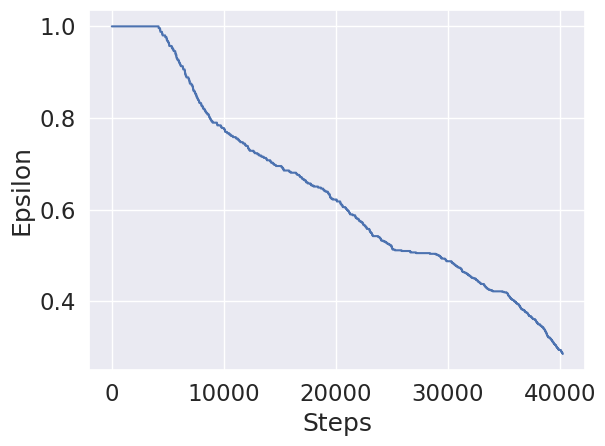

In [33]:
plot_exploration_rate(epsilons, figpath=CURRENT_PATH)

### States & actions distributions

In [34]:
def postprocess(episodes, p, rewards, steps):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": episodes.tile(p.n_runs).cpu(),
            "Rewards": rewards.T.flatten().cpu(),
            "Steps": steps.T.flatten().cpu(),
        }
    )
    # res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    return res

In [35]:
res = postprocess(episodes, p, rewards, steps)
res

,Episodes,Rewards,Steps
0,0,0.0,128.0
1,1,0.0,68.0
2,2,10.0,178.0
3,3,10.0,159.0
4,4,10.0,76.0
...,...,...,...
9995,495,10.0,28.0
9996,496,10.0,9.0
9997,497,10.0,10.0
9998,498,10.0,6.0


As a sanity check, we will plot the distributions of states and actions
with the following function:

In [36]:
def plot_actions_distribution(actions, figpath=None):
    """Plot the distributions of states and actions."""
    fig, ax = plt.subplots()
    sns.histplot(data=actions, ax=ax)
    ax.set_xticks(
        [item.value for item in Actions], labels=[item.name for item in Actions]
    )
    ax.set_title("Actions")
    fig.tight_layout()
    if figpath:
        fig.savefig(
            figpath / "actions-distribution.png", bbox_inches="tight", transparent=True
        )
    plt.show()

Exception ignored in: <function ZipFile.__del__ at 0x7f432f9fb6a0>
Traceback (most recent call last):
  File "/oscar/runtime/software/external/python/3.11.0/lib/python3.11/zipfile.py", line 1870, in __del__
    self.close()
  File "/oscar/runtime/software/external/python/3.11.0/lib/python3.11/zipfile.py", line 1887, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


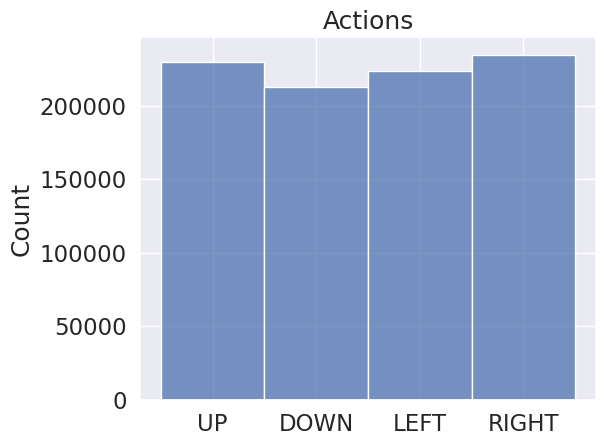

In [37]:
plot_actions_distribution(all_actions, figpath=CURRENT_PATH)

### Steps & rewards

In [38]:
def plot_steps_and_rewards(df, figpath=None):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data=df, x="Episodes", y="Rewards", ax=ax[0])
    ax[0].set(
        ylabel=f"Rewards\naveraged over {p.n_runs} runs" if p.n_runs > 1 else "Rewards"
    )

    sns.lineplot(data=df, x="Episodes", y="Steps", ax=ax[1])
    ax[1].set(
        ylabel=(
            f"Steps number\naveraged over {p.n_runs} runs"
            if p.n_runs > 1
            else "Steps number"
        )
    )

    fig.tight_layout()
    if figpath:
        fig.savefig(
            figpath / "steps-and-rewards.png", bbox_inches="tight", transparent=True
        )
    plt.show()

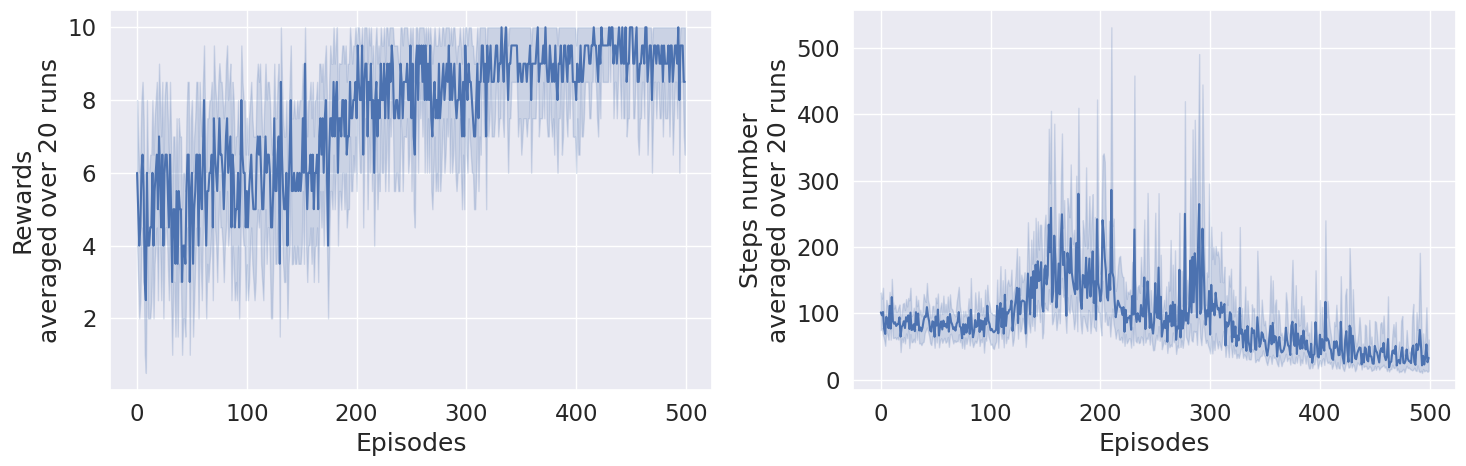

In [39]:
plot_steps_and_rewards(res, figpath=CURRENT_PATH)

In [40]:
def plot_steps_and_rewards_dist(df, figpath=None):
    """Plot the steps and rewards distributions from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=df, x="Rewards", ax=ax[0])
    sns.histplot(data=df, x="Steps", ax=ax[1])
    fig.tight_layout()
    if figpath:
        fig.savefig(
            figpath / "steps-and-rewards-distrib.png",
            bbox_inches="tight",
            transparent=True,
        )
    plt.show()

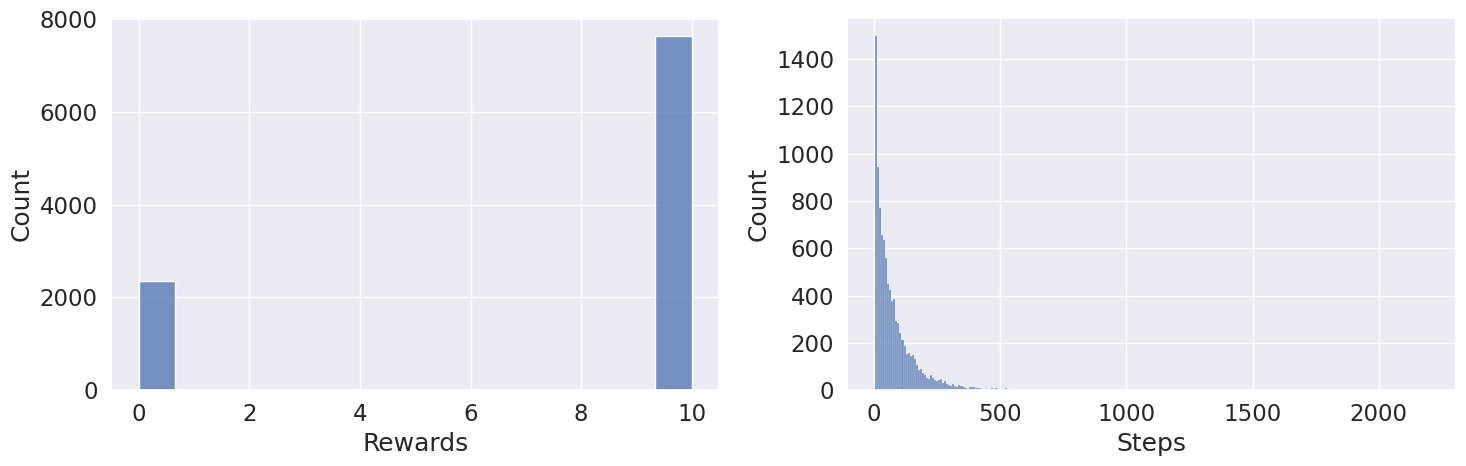

In [41]:
plot_steps_and_rewards_dist(res, figpath=CURRENT_PATH)

### Loss

In [42]:
window_size = 10
for idx, loss in enumerate(losses):
    current_loss = torch.tensor(loss, device=device)
    losses_rolling_avg = nn.functional.avg_pool1d(
        current_loss.view(1, 1, -1), kernel_size=window_size
    ).squeeze()
    tmp_df = pd.DataFrame(
        data={
            "Run": idx * torch.ones(len(losses_rolling_avg), device=device).int().cpu(),
            "Steps": torch.arange(0, len(losses_rolling_avg), device=device).cpu(),
            "Loss": losses_rolling_avg.cpu(),
        }
    )
    if idx == 0:
        loss_df = tmp_df
    else:
        loss_df = pd.concat((loss_df, tmp_df))
loss_df

,Run,Steps,Loss
0,0,0,0.001015
1,0,1,0.000837
2,0,2,0.000959
3,0,3,0.000851
4,0,4,0.001053
...,...,...,...
4019,19,4019,0.002275
4020,19,4020,0.002231
4021,19,4021,0.002429
4022,19,4022,0.001860


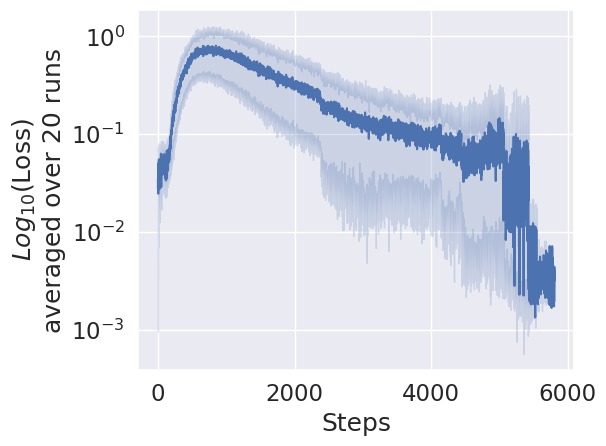

In [43]:
fig, ax = plt.subplots()
sns.lineplot(data=loss_df, x="Steps", y="Loss", ax=ax)
ax.set(
    ylabel=(
        f"$Log_{{10}}(\\text{{Loss}})$\naveraged over {p.n_runs} runs"
        if p.n_runs > 1
        else "$Log_{10}(\\text{Loss})$"
    )
)
ax.set(xlabel="Steps")
ax.set(yscale="log")
fig.tight_layout()
fig.savefig(CURRENT_PATH / "loss.png", bbox_inches="tight", transparent=True)
plt.show()

### Policy learned

In [44]:
with torch.no_grad():
    q_values = torch.nan * torch.empty(
        (len(env.tiles_locations), len(Cues), p.n_actions), device=device
    )
    for tile_i, tile_v in enumerate(env.tiles_locations):
        for cue_i, cue_v in enumerate(Cues):
            state = torch.tensor([tile_v, cue_v.value], device=device).float()
            if env.one_hot_state:
                state = env.to_one_hot(state).float()
            q_values[tile_i, cue_i, :] = net(state).to(device)
q_values.shape

torch.Size([25, 3, 4])

In [45]:
def qtable_directions_map(qtable, rows, cols):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).values.reshape(rows, cols)
    qtable_best_action = qtable.argmax(axis=1).reshape(rows, cols)
    directions = {
        Actions.UP: "↑",
        Actions.DOWN: "↓",
        Actions.LEFT: "←",
        Actions.RIGHT: "→",
    }
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = torch.finfo(torch.float64).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[Actions(val.item())]
    qtable_directions = qtable_directions.reshape(rows, cols)
    return qtable_val_max, qtable_directions

In [46]:
def plot_policies(q_values, labels, figpath=None):
    """Plot the heatmap of the Q-values.

    Also plot the best action's direction with arrows."""

    fig, ax = plt.subplots(1, 3, figsize=(13, 4))
    for idx, cue in enumerate(labels):
        qtable_val_max, qtable_directions = qtable_directions_map(
            qtable=q_values[:, idx, :], rows=env.rows, cols=env.cols
        )
        sns.heatmap(
            qtable_val_max.cpu(),
            annot=qtable_directions,
            fmt="",
            ax=ax.flatten()[idx],
            cmap=sns.color_palette("Blues", as_cmap=True),
            linewidths=0.7,
            linecolor="black",
            xticklabels=[],
            yticklabels=[],
            annot_kws={"fontsize": "xx-large"},
            cbar_kws={"label": "Q-value"},
        ).set(title=labels[cue])
        for _, spine in ax.flatten()[idx].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(0.7)
            spine.set_color("black")

        # Annotate the ports names
        bbox = {
            "facecolor": "black",
            "edgecolor": "none",
            "boxstyle": "round",
            "alpha": 0.1,
        }
        ax.flatten()[idx].text(
            x=4.7,
            y=0.3,
            s="N",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=4.9,
            s="S",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=4.7,
            y=4.9,
            s="E",
            bbox=bbox,
            color="white",
        )
        ax.flatten()[idx].text(
            x=0.05,
            y=0.3,
            s="W",
            bbox=bbox,
            color="white",
        )

    # Make background transparent
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor("white")
    fig.tight_layout()
    if figpath:
        fig.savefig(figpath / "policy.png", bbox_inches="tight", transparent=True)
    plt.show()

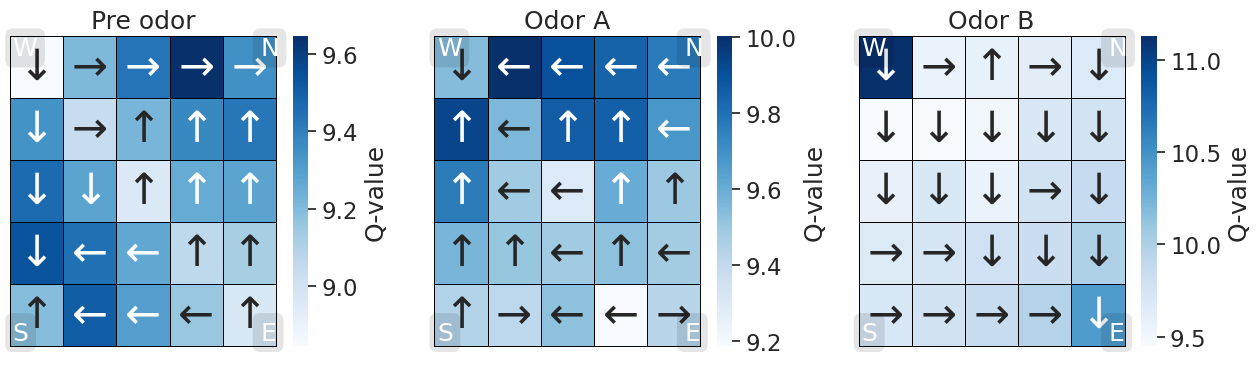

In [47]:
plot_policies(q_values=q_values, labels=CONTEXTS_LABELS, figpath=CURRENT_PATH)

### Weights & gradients metrics

In [48]:
weights, biases = collect_weights_biases(net=net)

In [49]:
def params_df_flat(weights):
    for idx, val in enumerate(weights):
        tmp_df = pd.DataFrame(
            data={
                "Val": val.detach().cpu().flatten(),
                "Layer": idx,
            }
        )
        if idx == 0:
            df = tmp_df
        else:
            df = pd.concat((df, tmp_df))
    return df

In [50]:
weights_val_df = params_df_flat(weights["val"])
weights_val_df

,Val,Layer
0,-0.001486,0
1,0.199440,0
2,0.163517,0
3,0.086189,0
4,-0.074254,0
...,...,...
507,0.103364,3
508,-0.185574,3
509,0.106831,3
510,0.011632,3


In [51]:
weights_val_df.describe()

,Val,Layer
count,36864.000000,36864.000000
mean,0.010508,1.375000
std,0.089634,0.675729
min,-0.665709,0.000000
25%,-0.046259,1.000000
50%,0.012356,1.000000
75%,0.069325,2.000000
max,0.645764,3.000000


In [52]:
biases_val_df = params_df_flat(biases["val"])
biases_val_df

,Val,Layer
0,-0.036801,0
1,-0.083125,0
2,0.273011,0
3,-0.020170,0
4,0.139780,0
...,...,...
127,0.092153,2
0,-0.011563,3
1,0.083114,3
2,0.054394,3


In [53]:
biases_val_df.describe()

,Val,Layer
count,388.000000,388.000000
mean,0.037938,1.020619
std,0.081693,0.838103
min,-0.176145,0.000000
25%,-0.025160,0.000000
50%,0.040934,1.000000
75%,0.099591,2.000000
max,0.273011,3.000000


In [54]:
weights_grad_df = params_df_flat(weights["grad"])
weights_grad_df

,Val,Layer
0,-0.001240,0
1,0.000000,0
2,0.000000,0
3,0.001749,0
4,0.000000,0
...,...,...
507,0.000125,3
508,0.002332,3
509,0.000067,3
510,0.003562,3


In [55]:
weights_grad_df.describe()

,Val,Layer
count,36864.000000,36864.000000
mean,0.000053,1.375000
std,0.001366,0.675729
min,-0.024654,0.000000
25%,-0.000048,1.000000
50%,0.000000,1.000000
75%,0.000161,2.000000
max,0.037759,3.000000


In [56]:
biases_grad_df = params_df_flat(biases["grad"])
biases_grad_df

,Val,Layer
0,-0.007014,0
1,0.008303,0
2,-0.001621,0
3,-0.006089,0
4,0.003384,0
...,...,...
127,0.000803,2
0,-0.006655,3
1,-0.001649,3
2,0.010451,3


In [57]:
biases_grad_df.describe()

,Val,Layer
count,388.000000,388.000000
mean,0.000386,1.020619
std,0.003078,0.838103
min,-0.010215,0.000000
25%,-0.000621,0.000000
50%,0.000124,1.000000
75%,0.001609,2.000000
max,0.012829,3.000000


In [58]:
def check_grad_stats(grad_df):
    grad_stats = torch.tensor(
        [
            grad_df.Val.mean(),
            grad_df.Val.std(),
            grad_df.Val.min(),
            grad_df.Val.max(),
        ],
        device=device,
    )
    assert not torch.equal(
        torch.zeros_like(grad_stats, device=device),
        grad_stats,
    ), "Gradients are zero"

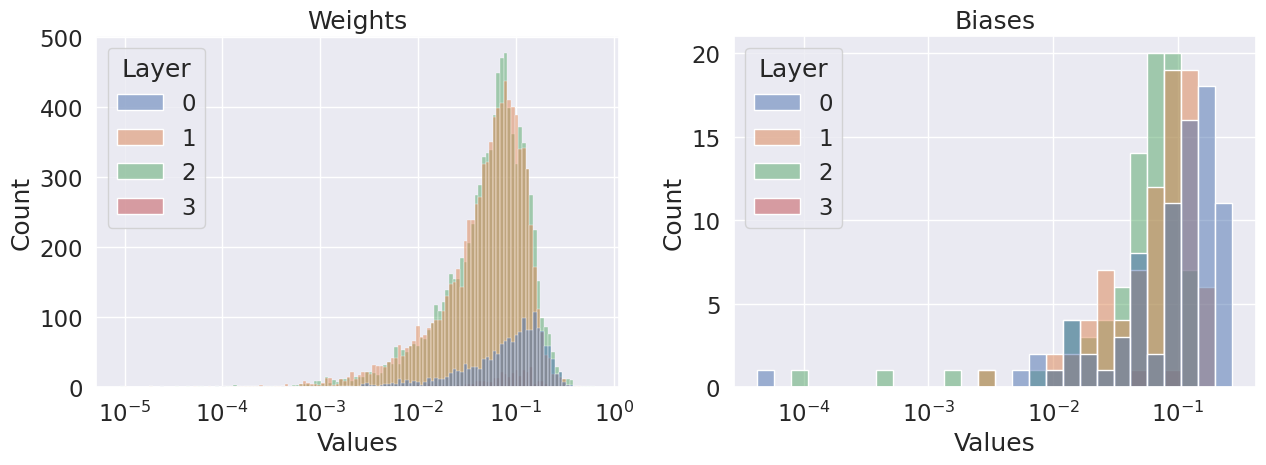

In [59]:
plotting.plot_weights_biases_distributions(
    weights_val_df, biases_val_df, label="Values", figpath=CURRENT_PATH
)

In [60]:
check_grad_stats(weights_grad_df)

In [61]:
check_grad_stats(biases_grad_df)

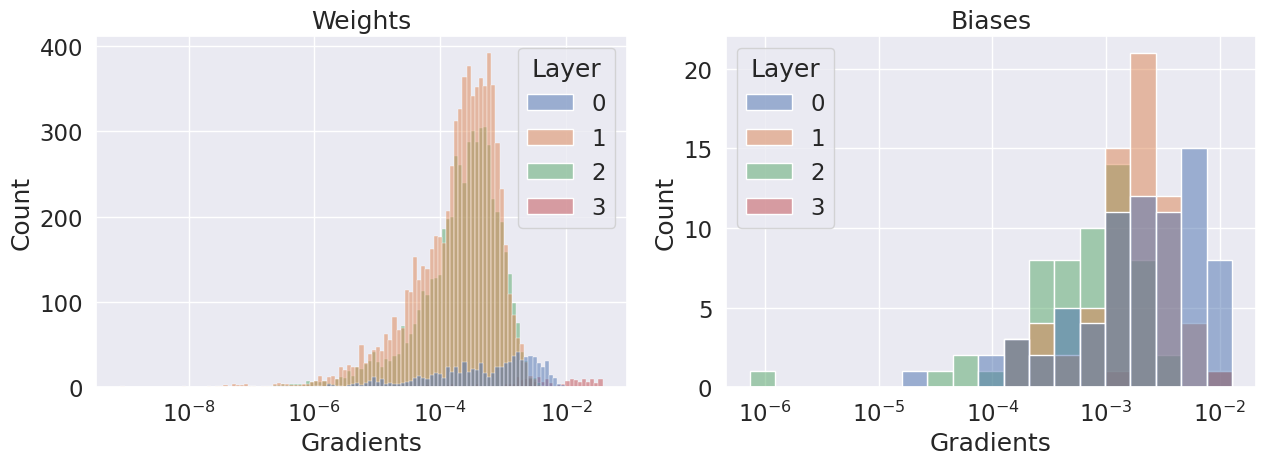

In [62]:
plotting.plot_weights_biases_distributions(
    weights_grad_df, biases_grad_df, label="Gradients", figpath=CURRENT_PATH
)

In [63]:
weights_val_stats

,Std,Avg,Layer
Index,,,
0,0.108742,-1.123984e-03,0
1,0.050951,1.304156e-04,1
2,0.051357,6.165473e-04,2
3,0.050177,4.338402e-03,3
4,0.000013,-2.027937e-07,0
...,...,...,...
321959,0.012210,-5.828003e-03,3
321960,0.122907,2.422176e-03,0
321961,0.084012,7.372373e-03,1


In [64]:
biases_val_stats

,Std,Avg,Layer
Index,,,
0,0.105036,-0.012771,0
1,0.048880,0.005694,1
2,0.048634,-0.001489,2
3,0.057262,-0.011227,3
4,0.105045,-0.012765,0
...,...,...,...
160979,0.053070,0.024335,3
160980,0.109358,0.048500,0
160981,0.066219,0.040300,1


In [65]:
weights_grad_stats

,Std,Avg,Layer
Index,,,
0,0.108742,-1.123984e-03,0
1,0.050951,1.304156e-04,1
2,0.051357,6.165473e-04,2
3,0.050177,4.338402e-03,3
4,0.000013,-2.027937e-07,0
...,...,...,...
321963,0.102898,3.229818e-02,3
321964,0.001475,4.640196e-05,0
321965,0.000506,4.279792e-05,1


In [66]:
biases_grad_stats

,Std,Avg,Layer
Index,,,
0,0.000056,-2.839111e-06,0
1,0.000165,6.278121e-07,1
2,0.000430,-3.988411e-05,2
3,0.006624,-3.310217e-03,3
4,0.000053,-3.497740e-06,0
...,...,...,...
160979,0.007737,-5.196281e-03,3
160980,0.004391,6.496273e-04,0
160981,0.002629,3.712893e-04,1


In [67]:
def plot_weights_biases_stats(weights_stats, biases_stats, label=None, figpath=None):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

    if label:
        ax[0, 0].set_title("Weights " + label)
    else:
        ax[0, 0].set_title("Weights")
    ax[0, 0].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[0, 0],
    )
    ax[0, 0].set(yscale="log")

    if label:
        ax[0, 1].set_title("Weights " + label)
    else:
        ax[0, 1].set_title("Weights")
    ax[0, 1].set_xlabel("Episodes")
    palette = sns.color_palette()[0 : len(weights_stats.Layer.unique())]
    sns.lineplot(
        data=weights_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[0, 1],
    )
    ax[0, 1].set(yscale="log")

    if label:
        ax[1, 0].set_title("Biases " + label)
    else:
        ax[1, 0].set_title("Biases")
    ax[1, 0].set_xlabel("Steps")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Std",
        hue="Layer",
        palette=palette,
        ax=ax[1, 0],
    )
    ax[1, 0].set(yscale="log")

    if label:
        ax[1, 1].set_title("Biases " + label)
    else:
        ax[1, 1].set_title("Biases")
    ax[1, 1].set_xlabel("Steps")
    palette = sns.color_palette()[0 : len(biases_stats.Layer.unique())]
    sns.lineplot(
        data=biases_stats,
        x="Index",
        y="Avg",
        hue="Layer",
        palette=palette,
        ax=ax[1, 1],
    )
    ax[1, 1].set(yscale="log")

    fig.tight_layout()
    if figpath:
        fig.savefig(
            figpath / f"weights-biases-stats-{label}.png",
            bbox_inches="tight",
            transparent=True,
        )
    plt.show()

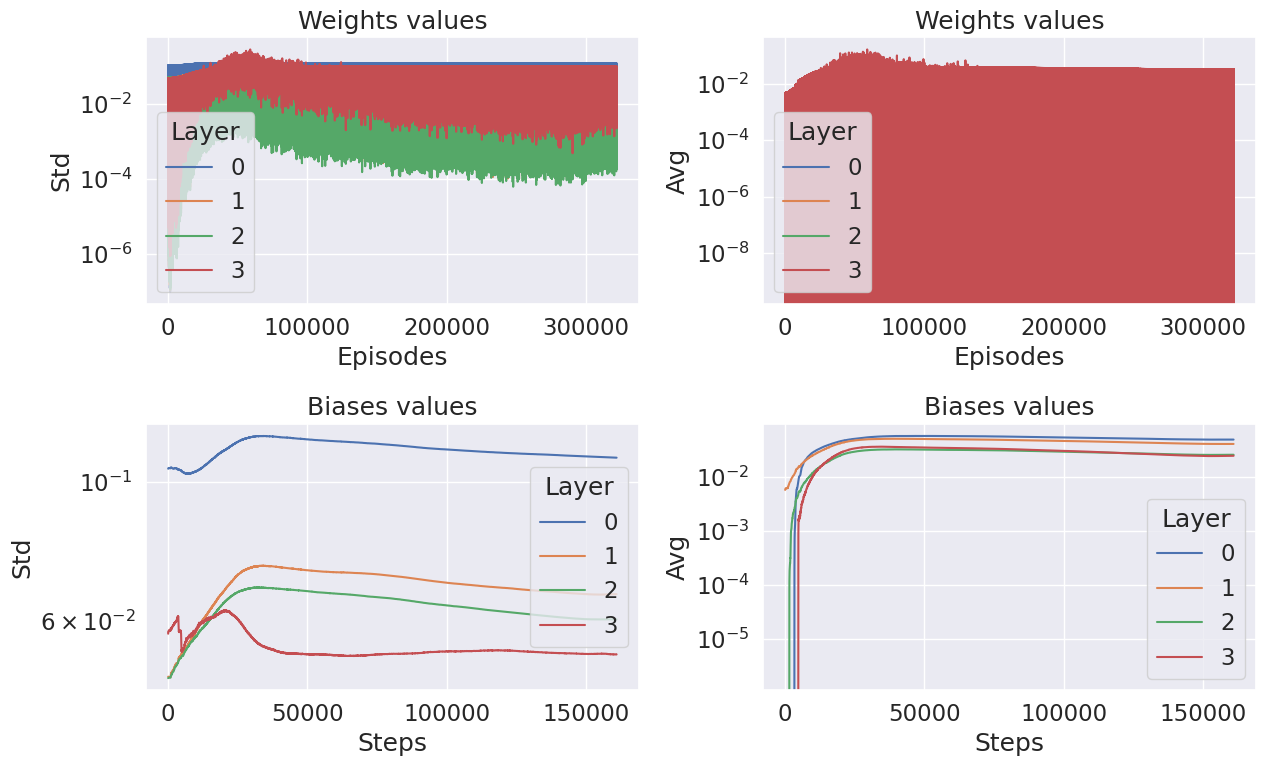

In [68]:
plot_weights_biases_stats(
    weights_val_stats, biases_val_stats, label="values", figpath=CURRENT_PATH
)

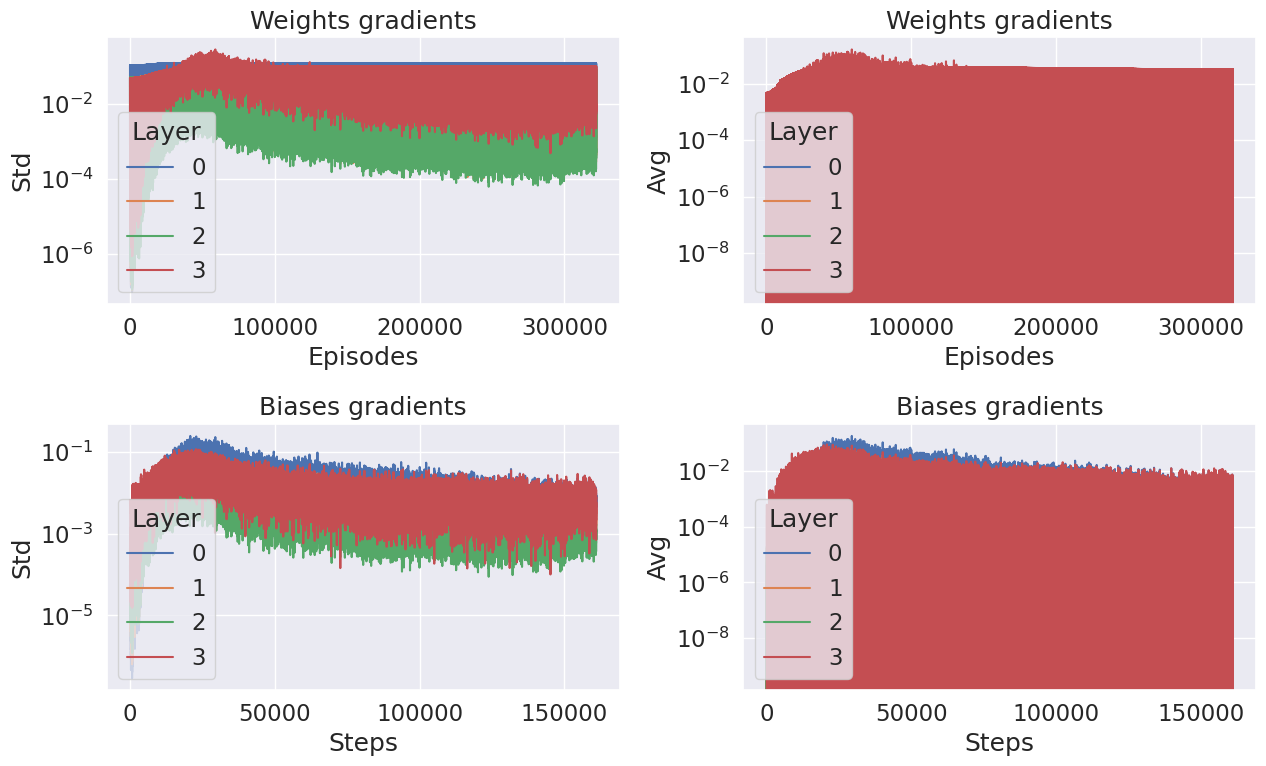

In [69]:
plot_weights_biases_stats(
    weights_grad_stats, biases_grad_stats, label="gradients", figpath=CURRENT_PATH
)

In [70]:
# weights_val_stats.rolling(10, center=True).mean().dropna()

In [71]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )

In [72]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )